<a href="https://colab.research.google.com/github/Ayush-ds-phy/Data_Analyst_bot/blob/main/Data_analyst_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#installing and importing libraries

!pip install together pandas matplotlib seaborn openpyxl pytesseract pdfplumber python-docx PyMuPDF

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytesseract
import pdfplumber
import docx
import together
from PIL import Image as PILImage
from IPython.display import Image, display


together.api_key = os.getenv("TOGETHER_API_KEY")

In [9]:
# Together API Query
#Function to send a prompt to LLaMA model and return the generated response.

def query_llama(prompt):
    try:
        response = together.Complete.create(
            model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
            prompt=prompt,
            max_tokens=512,
            temperature=0.7,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print("# Error from Together API:", e)
        return None



In [8]:

# Handles text extraction from various file types like `.csv`, `.xlsx`, `.pdf`, `.docx`, and images.

def text_ex(file):
    if file.name.endswith('.csv'):
        df = pd.read_csv(file)
        return df

    elif file.name.endswith('.xlsx'):
        df = pd.read_excel(file)
        return df

    elif file.name.endswith('.txt'):
        return file.read().decode()

    elif file.name.endswith('.pdf'):
        with pdfplumber.open(file) as pdf:
            text = ''
            for page in pdf.pages:
                text += page.extract_text() + '\n'
            return text

    elif file.name.endswith('.docx'):
        doc = docx.Document(file)
        return '\n'.join([para.text for para in doc.paragraphs])

    elif file.name.endswith(('.png', '.jpg', '.jpeg')):
        image = Image.open(file)
        text = pytesseract.image_to_string(image)
        return text


In [13]:
# Data loading and Visualisation

def load_data(file):
    try:
        if file.endswith(".csv"):
            return pd.read_csv(file, encoding='utf-8')
        elif file.endswith((".xls", ".xlsx")):
            return pd.read_excel(file)
    except UnicodeDecodeError:
        print("⚠️ utf-8 decoding failed. Retrying with latin1 encoding...")
        return pd.read_csv(file, encoding='latin1')

def visualize(df):
    numeric_cols = df.select_dtypes(include='number').columns

    # 1. Histograms for first 3 numeric columns
    for col in numeric_cols[:3]:
        plt.figure(figsize=(8, 5))
        df[col].plot(kind="hist", bins=20, title=f"Histogram of {col}", color='skyblue', edgecolor='black')
        plt.xlabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{col}_hist.png")
        plt.close()

    # 2. Correlation heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.savefig("correlation_heatmap.png")
        plt.close()

    # 3. Riders over time chart (fixing date format!)
    if 'dteday' in df.columns and 'riders' in df.columns:
        try:
            df['datetime'] = pd.to_datetime(df['dteday'], dayfirst=True) + pd.to_timedelta(df['hr'], unit='h')
            daily = df.groupby('datetime')['riders'].sum().reset_index()
            plt.figure(figsize=(12, 5))
            plt.plot(daily['datetime'], daily['riders'], color='green')
            plt.title("Riders Over Time")
            plt.xlabel("Date-Time")
            plt.ylabel("Total Riders")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig("riders_time_series.png")
            plt.close()
        except Exception as e:
            print("Couldn't create time series chart:", e)




In [21]:
#Display All Saved PNG Charts
# Automatically display all `.png` visualizations in the notebook.

def show_images():
    import glob
    for filename in sorted(glob.glob("*.png")):
        print(f"📈 Showing {filename}")
        display(Image(filename=filename))

In [11]:
# Generate Business Insights and Recommendations
# Uses LLaMA to provide insights and strategic suggestions based on the dataset.

def conclusion_and_recommendations(df):
    prompt = f"""
    You are a senior data analyst helping a startup prepare insights for early-stage fundraising.

    Here is the data snapshot:
    {df.head(10).to_string()}

    Please provide:
    1. Key insights and patterns from the data
    2. At least 2 business recommendations
    3. A conclusion in 2-3 lines to help stakeholders understand the value of this data
    """

    response = query_llama(prompt)
    return response


In [4]:
# Main Function to Run Everything
# Handles both data file and document uploads, visualizations, and AI-based analysis.

def agent(file):
    if file.endswith((".csv", ".xls", ".xlsx")):
        df = load_data(file)
        print("# ✅ DataFrame Loaded:")
        print(df.head())

        visualize(df)
        print("# 📊 Charts saved as PNGs.")
        show_images()
        # Generate insights + recommendations
        response = conclusion_and_recommendations(df)
        print("\n🔍 LLaMA Final Output:\n", response)

    elif file.endswith((".pdf", ".docx", ".txt", ".png", ".jpg", ".jpeg")):
        text = text_ex(file)
        print("# 📄 Text Preview:")
        print(text[:1000])

        prompt = f"You are an intelligent document analyst. Read and summarize this:\n{text[:3000]}"
        response = query_llama(prompt)
        print("\n# Summary:\n", response)

    else:
        print("# ❌ Error: Unsupported file type.")



In [18]:
# Upload File to Start Analysis
#Use this cell to upload a file and trigger the full analysis pipeline.
from google.colab import files
uploaded = files.upload()

Saving bike_share_yr_0.csv to bike_share_yr_0 (2).csv


In [19]:
import os
os.environ['TOGETHER_API_KEY'] = "tgp_v1_m2Pf3DeoorE6rrTD1ESC74IXgfvFqZ5lJW4aUPF2TyA" # I have put my Api key for testing

# ✅ DataFrame Loaded:
     dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  1/1/2021       1   0     1   0        0        6           0           1   
1  1/1/2021       1   0     1   1        0        6           0           1   
2  1/1/2021       1   0     1   2        0        6           0           1   
3  1/1/2021       1   0     1   3        0        6           0           1   
4  1/1/2021       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed rider_type  riders  
0  0.24  0.2879  0.81        0.0     casual       3  
1  0.22  0.2727  0.80        0.0     casual       8  
2  0.22  0.2727  0.80        0.0     casual       5  
3  0.24  0.2879  0.75        0.0     casual       3  
4  0.24  0.2879  0.75        0.0     casual       0  
# 📊 Charts saved as PNGs.
📈 Showing correlation_heatmap.png


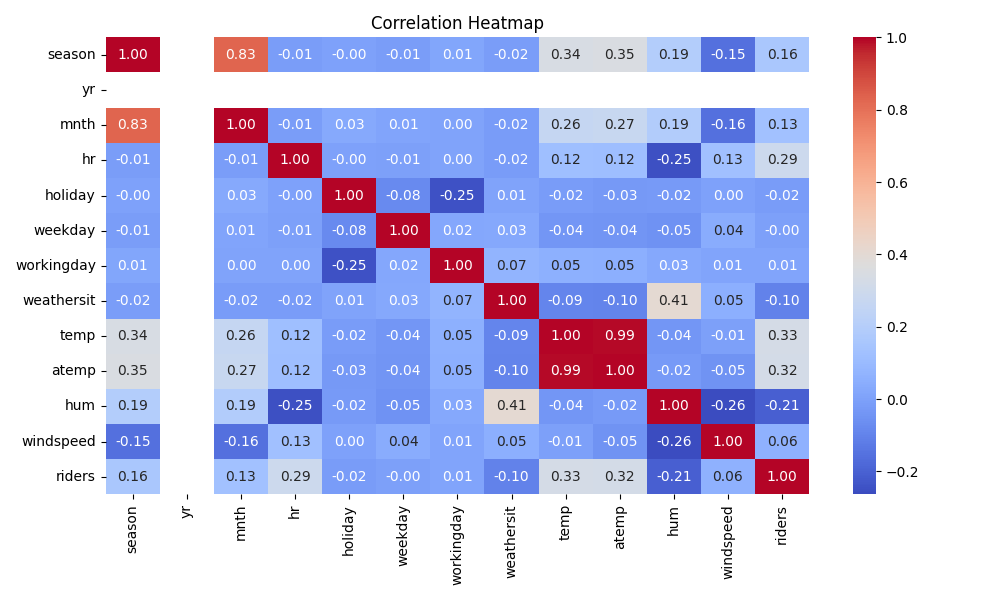

📈 Showing mnth_hist.png


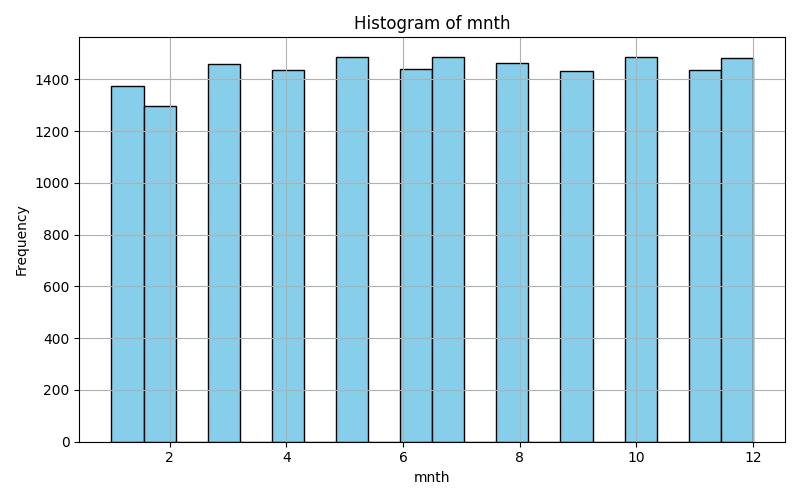

📈 Showing riders_time_series.png


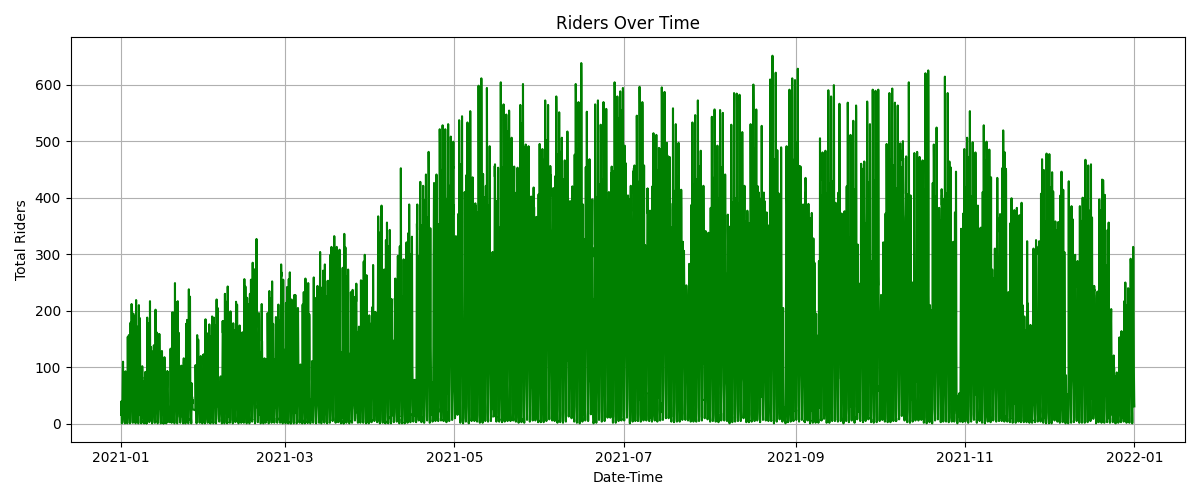

📈 Showing season_hist.png


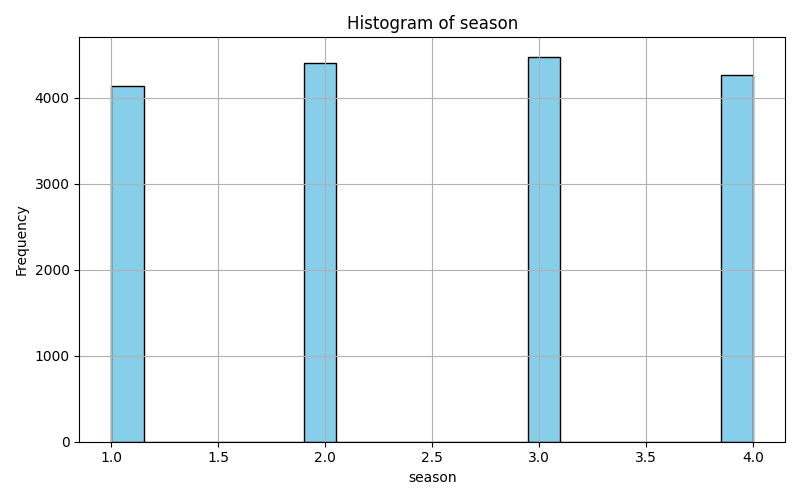

📈 Showing yr_hist.png


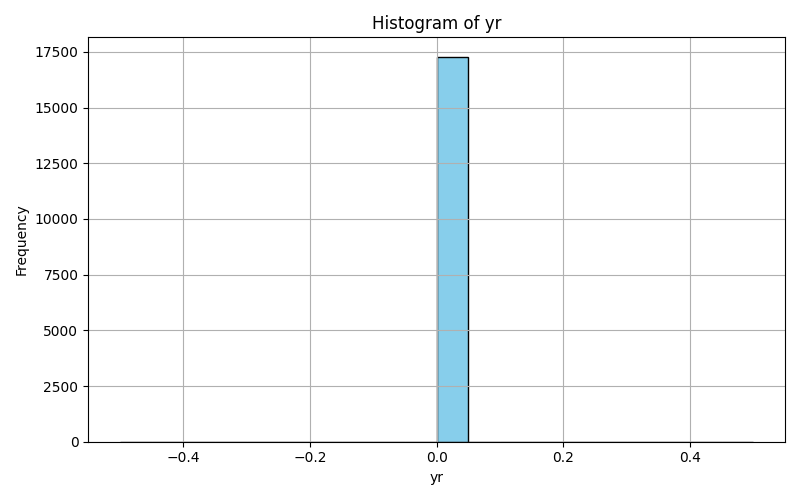

<ipython-input-9-504223002>:6: DeprecationWarning: Call to deprecated function create.
  response = together.Complete.create(
/usr/local/lib/python3.11/dist-packages/together/legacy/complete.py:23: UserWarning: The use of together.api_key is deprecated and will be removed in the next major release. Please set the TOGETHER_API_KEY environment variable instead.
  warnings.warn(API_KEY_WARNING)



🔍 LLaMA Final Output:
 for fundraising purposes.


## Step 1: Understand the given data snapshot
The provided data snapshot appears to be related to bike rental or sharing services, with various columns such as date, time, weather conditions, temperature, and the number of riders. The data includes information on the type of riders (casual), the number of riders, and other environmental factors.

## Step 2: Identify key insights and patterns from the data
Upon examining the data, we can observe the following:
- The data is hourly, covering a specific date (1/1/2021) and includes various environmental and temporal factors.
- The number of casual riders varies significantly across different hours of the day.
- The weather conditions, temperature, and humidity are also recorded, which could influence the number of riders.
- The data suggests that there are more riders during certain hours (e.g., 01:00, 09:00) than others (e.g., 04:00, 05:00).

## Step 3: Analyze the hourly distribution o

In [24]:
agent("bike_share_yr_0.csv") # the name of my file was bike_share_yr_0.csv